In [35]:
# Definitions and framework

import os
import json
import requests
import webbrowser
import ipynbname
import ipywidgets as widgets

debug_log=False

def my_print(what):
    if debug_log:
        print(what)
        
def get_session_data():                
    sess_data="""
    {
      "sessions": [
        {
          "id": 1,
          "language": "c++",
          "source": "",
          "compilers": [
            {
              "id": "g82",
              "options": "-O3"
            }
          ],
          "executors": [
            {
              "arguments": "arg1",
              "compiler": {
                  "id": "g92",
                  "libs": [],
                  "options": "-O3"
              },
              "stdin": ""
            }
          ]
        }
      ]
    }
    """
    return sess_data

def get_this_doc_name():
    this_doc_path=ipynbname.path()
    print('This document is stored into: {}'.format(this_doc_path))
    return this_doc_path

def invoke_compiler_explorer():    
    f=open(get_this_doc_name())
    js=json.load(f)
    for i in js['cells']:
        if i['cell_type']!='raw':
            # print(f'not raw: {i["id"]}')
            continue
        if 'metadata' not in i:
            print(f'no meta: {i["id"]}')
            continue
        meta=i['metadata']
        if 'tags' not in meta:
            print(f'no tags: {i["id"]}')
            continue
        tags=meta['tags']
        if 'C++' not in tags:
            print(f'no C++ tag: {i["id"]}')
            continue
        else:
            my_print('markdown source: {}'.format(i['source']))
            s=i['source']
            ss=''.join(s)
            my_print('source oneliner: {}'.format(ss))
            s2j=json.loads(get_session_data())
            s2j['sessions'][0]['source']=ss
            s2d=json.dumps(s2j)
            headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
            my_print('s2d: {}'.format(s2d))
            resp=requests.post("https://godbolt.org/api/shortener", data=s2d, headers=headers)
            my_print('resp2: {}, {}'.format(resp.status_code,resp.text))
            if resp.status_code==200:
                respo=json.loads(resp.text)
                url=respo['url']
                webbrowser.open(url,new=2)
            else:
                print('Compiler Explorer clientstate call failure')


In [36]:
# some handy functions to use along widgets
from IPython.display import display, Markdown, clear_output
# widget packages
import ipywidgets as widgets# defining some widgets
text = widgets.Text(value='My Text',description='Title',)
calendar = widgets.DatePicker(description='Select Date')
slider = widgets.FloatSlider(value=1,min=0,max=10.0,step=0.1,)
menu = widgets.Dropdown(options=['red', 'blue', 'green'],value='red',description='Color:')
checkbox = widgets.Checkbox(description='Check to invert',)

# The JSONIZER

This Jupyter Notebook file describes the Jsonizer, i.e. the C++ source code *jsonizer.cpp*.

# DO THIS FIRST

Run this Notebook in JupyterLab, not Jupyter Notebook, as the "hide code" seems to work better in JupyterLab.

You'll need to pre-install at least graphviz and ipywidgets, possibly tweak some settings.

**TODO: LET'S FIGURE OUT WHAT PREPARATIONS NEED TO BE DONE IN A VIRGIN ENVIRONMENT.**

The first thing to do after opening is to **View / Collapse All Code**.

The second thing to do after opening is to **Run / Run All Cells**.

This is to keep the document easier to view. You can later open and view the code as you please.

## Document Info

This notebook contains action buttons for transferring the source code into the Compiler Explorer (https://godbolt.org/) web page for a quick compile and demo run. 

This functionality, plus the "hide code" functionality seems to work best in JupyterLab (3.5.2), whereas the Jupyter Notebook (6.5.2) doesn't seem to work as well.

The buttons reside at the end of this file for the whole application and at select locations for runnable code snippets. Not every detail gets its own transfer button, but just copy/paste the code you'd like to experiment with into the Compiler Explorer or whichever other environment you prefer, and make your own int main() for the experiment.

Note that I won't always bother to copy code snippets in question into the following chapters. You might want to get two side-by-side browser windows for keeping the source code location and the discussion in sync.

Should you edit this file, the functionally relevant details are:

* the C++ source code snippet cells should be in Raw format. The Markdown format seems to eat e.g. the angle brackets of include statements, and most likely other C++ syntax too
* the C++ snippets to get transferred with the buttons must have the tags "C++" and "source-N" where the N is an identifier for that particular snippet.

## Purpose

As the name might imply, *jsonizer.cpp* creates JSON objects. It is intended for forming large and complex JSON with semi-random keys and values.

However, this is just the surface of what jsonizer.cpp is. It serves two other purposes:

* to provide SUT for a threaded application debugging session, with gdb
* to demonstrate a hefty list of (mostly) modern C++ features and some interesting and perhaps even useful implementations of said features.

The following chapters outline the features of interest roughly in the order where they appear in the source code.

## std::chrono_literals

The *chrono_literals* is a namespace that enables us to use timing related postfixes to numbers. For instance, you might want to sleep for *500ms*. The common usage of *chrono_literals* is to include *chrono* and then use the namespace in a .cpp file (never in a header as namespace pollution is just a bad practice):

    using namespace std::chrono_literals;

## enum class

The "old" *enum*s are essentially just a form or named integer constants. The *enum class* on the other hand is in addition an actual type, which doesn't do automatic conversion to integer. Type safety is one of the strong points of C++, so embrace enum classes wherever "just a form or named integer constants" isn't what you really need from enums.

## Initializer lists

The initializer list is a convenient and compact way to intialize containers. Jsonizer uses them all over the place. Example:

    std::vector<int> v{1,2,3};

## The LOG macro

The LOG macro is intended for thread safe debug or other *stdout* targeting logging. Essentially:

    LOG("string: " << myString << " and int: " << myInt)

equals:

    std::cout << "string: " << myString << " and int: " << myInt << std::endl;

## The jsonizer.cpp substantives

"What's life without whimsy" said a wise man once (who?). The Jsonizer uses semi random names as the keys of the key-value pairs it outputs to JSON. These names are hand-picked and sometimes "substantized" from the venerable **Webster's Encyclopedic Unabridged Dictionary of the English Language**. With its over 1800 large pages of small print, this book is a remarkable specimen from the era when everybody's nose wasn't yet glued to a smartphone screen.

Note that the key generation also utilizes a "Base-N" template for postfixing the substantives in order to create a sufficient amount of unique names. More about that one later.

## Random numbers

The classic C library provides the *rand()* library function, which has a number of shortcomings, and which probably shouldn't be used for critical application.

The more modern way to get random numbers is to use *std::random_device* as a non-deterministic random number generator, or due to performance issues, more often as the seed generator for other random number generators like the Mersenne Twister (*std::mt19937*) pseudo random generator.

## Tuples

Tuples are lists of predetermined sizes of heterogeneous items. The Jsoniser uses them quite a lot. See the template functions named *tie*N*()*. These are tool functions for the totally awesome *init()* variadic lambda, one of the cherries-on-top of the Jsonizer.

Even though the source code walkthrough has now advanced to the *init()* implementation, I'll postpone the introduction of the variadic lambda until a bit later.

## The DisNDat<> class

The *DisNDat* template class is nothing special language-wise. But it is a convenient way to aid producing comma (or other) separated text, or otherwise act as a differentiator of "first" and "the rest".

Just as an example, consider which of the following is more convenient:

    while(condition)
       {
       if(first)
          {
          std::cout << ",";
          first=false;
          }
       std::cout << something;
       possibly_alter(condition);
       }
   
or:

    DisNDat<> c("",",");
    while(condition)
       {
       std::cout << c << something;
       possibly_alter(condition);
       }

## The getFrom() pattern

The *getFrom()* template function and it's tools of templatized and *std::string* *conv()* functions is a common and convenient way of mixing and matching generic and specific types handling.

## The Part class

The *Part* class is one of the key components of Jsonizer. It models a unique, hierarchical, named or nameless "item", which in practice is a simple type like an integer, a double, a string, or a container like an array or an object. 

The *Part* class also offers a bookkeeping helper for keeping count of the contained simple typed items in the form of the *valueCount()* member. This in turn is needed for the thread terminate exit condition handling. 

Note that the *valueCount()* could use some optimization, as now it is implemented as "*recurse for the same piece of information over and over again*".

Note also that the *ostream operator* for *Part* offers a prime example of the usefullness of the *DisNDat* template class.

Note also the usage of *std::optional<>*. This is a gread addition to the language for those cases where e.g. *nullptr* vs. non-null just doesn't provide enough information of what a value represents. A "not exists" and "null" just aren't the same thing.

## Mutexes

The C++ standard comes with a few different ways to ensure a critical section in a code gets serialized. The Jsonizer uses *std::shared_mutex*, which models a "*single writer, multiple readers*". For our queue based data transfer between threads, this seems an obvious choice.

The *shared_mutex* is used by the thread safe *MuxPart* wrapper of the *Part* class.

Jsonizer also uses *std::mutex* within the *LOG* macro and in the context of *std::condition_variable*s. More about that later.

## The BaseN<> class

The *BaseN* template class offers a simple implementation for converting integers (i.e. Base-10) into more compact integer representations. As the implementation doesn't jump over the "unpretty" characters between digits and capital letters nor capitals and lowercase letters, it's readably usable only until Base-26. Furthermore, the implementation offers only pre- and post increments, plus a dereference operator. While many parts of the Jsonizer may be overengineered, this class is an exception.

## The KeyGetter class

The virtual *KeyGetter* class brings together a container of base names and an automatically extending postfix. It utilizes the *BaseN<>* class. This class also slices the namespace according to the count of name-needing clients.

## The SimpleValueGenerator<> class

The *SimpleValueGenerator* template class randomly picks values from the given list of values. The implementation uses this class only for the JSON base types of ints, doubles and strings. 

Note that this would be a good candidate to be a *virtual* class, as it offers only a single *get()* interface to clients. However currently it is also bound to the *Part* class. This could instead be a template argument.

## The Factory class hierarchy

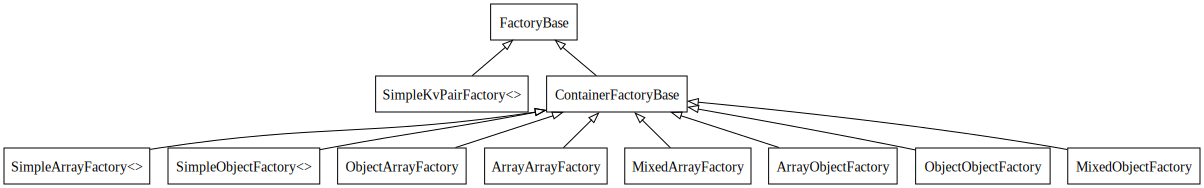

In [37]:
import graphviz

def viz(nodes: dict, edges: list):
    graph=graphviz.Digraph('node')
    graph.graph_attr['rankdir']='BT'
    graph.edge_attr.update(arrowhead='onormal')
    node_data=[graph.node(node['name'],node['label'],shape=node['shape']) for node in nodes]
    edge_data=[graph.edge(edge[0],edge[1]) for edge in edges]
    # print(graph)
    return graph

nodes=[
    
    {'name':'n1','label':'FactoryBase','shape':'box'}
    ,{'name':'n2','label':'SimpleKvPairFactory<>','shape':'box'}
    ,{'name':'n3','label':'ContainerFactoryBase','shape':'box'}
    ,{'name':'n4','label':'SimpleArrayFactory<>','shape':'box'}
    ,{'name':'n5','label':'SimpleObjectFactory<>','shape':'box'}
    ,{'name':'n6','label':'ObjectArrayFactory','shape':'box'}
    ,{'name':'n7','label':'ArrayArrayFactory','shape':'box'}
    ,{'name':'n8','label':'MixedArrayFactory','shape':'box'}
    ,{'name':'n9','label':'ArrayObjectFactory','shape':'box'}
    ,{'name':'n10','label':'ObjectObjectFactory','shape':'box'}
    ,{'name':'n11','label':'MixedObjectFactory','shape':'box'}
]
edges=[['n2','n1'],['n3','n1'],['n4','n3'],['n5','n3'],['n6','n3'],['n7','n3'],['n8','n3'],['n9','n3'],['n10','n3'],['n11','n3']]
viz(nodes,edges)

The *Factory* class hierarchy is responsible for creating *Part*s. A *Part* is an entity that is convertible to JSON data, i.e. a simple key-value pair, a keyed array containing non-keyed values, or an object. The concept is that of a components assembly line where first appears bare values, which then a *SimpleKvPairFactory* instance picks up and joins with a key, thus forming an elementary *Part*, which then either gets recircled back to the components assembly line to be a component of a larger *Part*, or which then gets moved to a products assembly line for further processing.

There are separate *Factory* classes for each of the possible JSON components: key-value pairs of simple values (ints, doubles and strings), arrays of simple kvpairs, arrays of arrays, arrays of objects, objects of simple kvpairs, objects of arrays, and objects of objects, plus arrays and objects of mixed subtypes. All of the container handling factories, based on *ContainerFactoryBase* pure virtual class, are constructed with min and max contained elements counts, and the processing algorithm then chooses randomly the count of elements based on that range.

The factories are constructed with a ratio for recirculating back to the components assembly line versus moving to the products assembly line. This should affect the complexity of the resulting JSON object.

The factories are also constructed with a weigth parameter. The assembly line algorithm is such that the HEAD *Part* of the *std::deque* modeled queue (i.e. "assembly line") is offered randomly to each of the *Factory* instances, until one of them consumes that *Part*.

Consider this offering procedure: if the HEAD is a simple string valued kvpair and it gets offered to a factory for arrays of simple integer valued kvpairs, the kvpair can't be accepted by that specific *Factory* instance. Consider also that the container handling factories will usually require several *Part*s from the assembly line to get their "job order" fulfilled. The following explains the acceptance procedure:

1. *SimpleKvPairFactory<INT>* accepts integers
2. *SimpleKvPairFactory<DOUBLE>* accepts doubles
3. *SimpleKvPairFactory<STRING>* accepts strings
4. *SimpleArrayFactory<INT>* accepts integers and INT kvpairs (drops key if such exists)
5. *SimpleArrayFactory<DOUBLE>* accepts doubles and DOUBLE kvpairs (drops key if such exists)
6. *SimpleArrayFactory<STRING>* accepts strings and STRING kvpairs (drops key if such exists)
7. *SimpleObjectFactory<INT>* accepts INT kvpairs
8. *SimpleObjectFactory<DOUBLE>* accepts DOUBLE kvpairs
9. *SimpleObjectFactory<STRING>* accepts STRING kvpairs
10. *ObjectArrayFactory* accepts objects
11. *ArrayArrayFactory* accepts arrays
12. *ArrayObjectFactory* accepts arrays
13. *ObjectObjectFactory* accepts objects
14. *MixedArrayFactory* accepts anything (drops key if such exists)
15. *MixedObjectFactory* accepts anything with a key

Only the first 6 "simple-consuming" factories, plus the *MixedArrayFactory*, can accept the "raw material". Only the factories 4.-9., plus the "Mixed" factories accept "second round" *Part*s. The rest will require "third round" or more complex *Part*s. Thus, it gets complicated to form arrays of objects of arrays of arrays or the like. The weigth may allow more chances for the more advanced factories to get their job completed, combined possibly with a greater ratio of recirculation for the simpler factories, and combined possibly with a suitable selection of min and max container sizes for each of the factories. The weigth may also be used to the other direction: for instance an array of mixed subtypes might not be very useful as a JSON entity, so it can be configured to be a nonexistent or rare *Part*.
    
A few notes about the implementation details of these factories. The interface for these is the *get(MuxParts&)* override. The *MuxParts* param is a thread safe accessor for the assembly line. The *get()* returns either null *std::shared_ptr* or a *std::shared_ptr* of a complete *Part*. Every factory checks the suitability of the assembly line received *Part* candidate, and for the container factories, they use the *bool match(PartPtr)* override for this purpose. The object factories need the extra step of ensuring that all the contained values (sub-parts one level down) have unique keys, as duplicate keys in objects are frowned upon by the JSON specification.

So, all in all, quite a complex machinery is required for "random complex JSON objects". There probably exists more sensible implementation ways for the end result, but the intent here was not only the end result but also the application of a producer-consumer threading model and a well-rounded utilization of C++ features.

## The ProducerParams class

The command line interface to Jsonizer is a late addition and perhaps not as well structured as the earlier code.

The *Producer* class requires quite a complicated initialization, and the intent was to be able to give (part of) the initialization data from command line. Instead of adding multi-argument constructor(s) for it, the code uses a separate "params" class, thus splitting the maintenance requirements. Now the command line -> params and params -> *Producer* construction are separated. Although any change to the *ProducerParams* will need corresponding fix to the *Producer* construction, and vice versa, at least the constructor interface to *Producer* stays intact. Sometimes such don't-break-interfaces approach is beneficial for maintenance, although here it doesn't matter that much.

The *ProducerParams* collects the min/max/recirc/weigth parameters for all the *Factory* classes, which the *Producer* then instantiates, and the keys and values available for the application.

## The Producer class

**TODO**


## The threading solution

The threading in Jsonizer is modeled after a producer/consumer idea. There exists a Producer thread, managed by the Producer class, which also consumes its own products, and a number of separate Consumer threads, managed by the Assembly classes.

The "business" model here is that there's a factory that produces Parts, and these in turn can form larger and more complex Parts, which eventually form Products. Consider a toy car. It has parts such as wheels, axles, baseplate, engine, chassis, hood, windows, doors, and properties such as dimensions, weigth, color, etc. A factory might get an order of 1,000 wheels. It might also get an order of 100 red sedan chassises having windows and doors, including hood and trunk lids. The Assembly instances - another factories perhaps - then would combine their orders into marketable products. Something of this sort, but all the keys and values of the produced key-value pairs are semi random. No wheels to be found.

Threads share data via queues. There's an input queue with values and Parts on their way to become more complex Parts, and there's an output queue, which are the order fulfillments of the Producer factory.

Both of these queues can get empty, which mean the user of those queues has nothing further to do, until another thread adds items to the queue. This is handled with condition variables, one for the Producer, another for the Assemblies. There are "standard" mutexes protecting access to the condition variables, and there are shared_mutexes for providing single writer - multiple readers access to the queues.

Here is a rough flowchart of this:

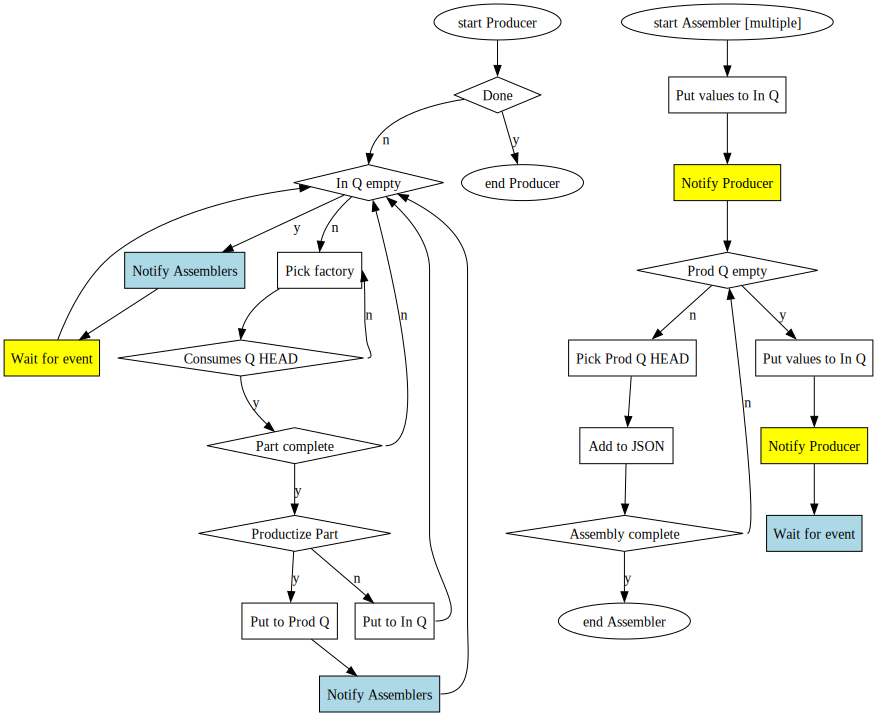

In [38]:
def vizflow(nodes: dict, edges: list):
    rootgraph=graphviz.Digraph('node')
    graph=graphviz.Digraph('node')
    graph.graph_attr['rankdir']='TB'
    node_data1=[graph.node(node['name'],node['label'],shape=node['shape'],style='filled',fillcolor=node.get('fillcolor','white')) for node in nodes]
    edge_data1=[graph.edge(edge[0],edge[1],label=edge[2]) for edge in edges]
    
    graph2=graphviz.Digraph('node')
    graph2.graph_attr['rankdir']='TB'
    node_data2=[graph2.node(node['name'],node['label'],shape=node['shape'],style='filled',fillcolor=node.get('fillcolor','white')) for node in nodes2]
    edge_data2=[graph2.edge(edge[0],edge[1],label=edge[2]) for edge in edges2]

    rootgraph.subgraph(graph)
    rootgraph.subgraph(graph2)
    return rootgraph

nodes=[
    {'name':'n1','label':'start Producer','shape':'oval'}
    ,{'name':'n2','label':'In Q empty','shape':'diamond'}
    ,{'name':'n9','label':'Notify Assemblers','shape':'rect','fillcolor':'lightblue'}
    ,{'name':'n10','label':'Wait for event','shape':'rect','fillcolor':'yellow'}
    ,{'name':'n3','label':'Pick factory','shape':'rect'}
    ,{'name':'n4','label':'Consumes Q HEAD','shape':'diamond'}
    ,{'name':'n5','label':'Part complete','shape':'diamond'}
    ,{'name':'n6','label':'Productize Part','shape':'diamond'}
    ,{'name':'n7','label':'Put to Prod Q','shape':'rect'}
    ,{'name':'n8','label':'Notify Assemblers','shape':'rect','fillcolor':'lightblue'}
    ,{'name':'n11','label':'Done','shape':'diamond'}
    ,{'name':'n12','label':'end Producer','shape':'oval'}
    ,{'name':'n13','label':'Put to In Q','shape':'rect'}
]
edges=[['n2','n3:n','n'],['n3','n4:n',''],['n4:s','n5','y']
       ,['n5','n6','y'],['n6','n7','y'],['n7','n8',''],['n8:e','n2','']
       ,['n4:e','n3:e','n'],['n5:e','n2','n'],['n6','n13','n']
       ,['n2','n9','y'],['n9','n10',''],['n10','n2','']
       ,['n1','n11',''],['n11','n2:n','n'],['n11','n12','y']
       ,['n13:e','n2','']
]
nodes2=[
    {'name':'m1','label':'start Assembler [multiple]','shape':'oval'}
    ,{'name':'m2','label':'Put values to In Q','shape':'rect'}
    ,{'name':'m3','label':'Notify Producer','shape':'rect','fillcolor':'yellow'}
    ,{'name':'m4','label':'Prod Q empty','shape':'diamond'}
    ,{'name':'m5','label':'Pick Prod Q HEAD','shape':'rect'}
    ,{'name':'m6','label':'Add to JSON','shape':'rect'}
    ,{'name':'m7','label':'Assembly complete','shape':'diamond'}
    ,{'name':'m8','label':'end Assembler','shape':'oval'}
    ,{'name':'m9','label':'Put values to In Q','shape':'rect'}
    ,{'name':'m10','label':'Notify Producer','shape':'rect','fillcolor':'yellow'}
    ,{'name':'m11','label':'Wait for event','shape':'rect','fillcolor':'lightblue'}
]
edges2=[['m1','m2',''],['m2','m3',''],['m3','m4',''],['m4','m5','n']
       ,['m5','m6',''],['m6','m7',''],['m7','m8','y'],['m4','m9','y']
       ,['m9','m10',''],['m10','m11',''],['m7:e','m4','n']
]
vizflow(nodes,edges)

## TODO: The init() variadic lambda

## TODO: The tieN() pattern

## TODO: Implementation commentary

## TODO: The Assembly class

## TODO: The cmdline handling

## TODO: Usage experimentation

## TODO: Missing functionality

## TODO: Compiler Explorer specifics (needs to be C++17 or newer and needs -lpthread compiler option)

## The full source code of jsonizer.cpp

In [39]:
get_this_doc_name()

This document is stored into: C:\Users\Micadesk\jsonizer2godbolt_20230911_4.ipynb


WindowsPath('C:/Users/Micadesk/jsonizer2godbolt_20230911_4.ipynb')

In [40]:
# pip install ipywidgets
# jupyter nbextension enable --py widgetsnbextension

In [41]:
button=widgets.Button(description='C++ to godbolt')
out=widgets.Output()
def on_button_click(_):
    with out:
        invoke_compiler_explorer()
button.on_click(on_button_click)
widgets.VBox([button,out])
